## DSGE w. Feedback - Numerical Simulations

### Imports

In [1]:
%load_ext autoreload
%autoreload 2
%aimport
%matplotlib notebook

Modules to reload:
all-except-skipped

Modules to skip:



In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import minimize

In [48]:
import model

## Simulation mechanics

In [112]:
def bound(z: float, gti: float, k: float, p:dict):
    """ Check whether we need to respect the bound on labour"""
    mu = abs(p['rho'])
    x = (z / gti) **  mu - (p['alpha'] / (k ** mu))
    if x < 0:
        return np.infty
    else:
        return ((1 - p['alpha']) / x) ** (1 / mu)


def bisection_CES(z:float, gti:float, k:float, ft_:float, p: dict, init:float=1e8):
    
    #print(z, gti, k)
    assert gti > 0, "Negative income"
    
    mu = -p['rho']
    gr = p['gamma'] * (1 + p['interest'])
    kmu = k ** mu
    
    pt1 = -1 * (1 - p['alpha']) * kmu 
    pt2 = 2 * ft_ * z + z
    pt3 = 4 * gti * gr
    pt4 = 2 * p['alpha'] * gr
    
    def ces(n: float):
        temp = p['alpha'] / kmu + (1 - p['alpha']) / (n ** mu)
        return z * (temp ** (- 1 / mu)) #ERROR -1/mu not 1/mu
    
    def val(n:float):
        n2 = n**2
        y = ces(n)
        x = pt1 * (pt2 - 2 * gr * z * n2 + pt3 * n2 * y - 2 * gti * y) #error 2 * gr * z * n2 
        return (x + pt4 * n2 * (n ** mu) * (z - 2 * gti * y))**4
        #if you use minimise then it should be a real minimum
    n0 = 1e-8
    b = bound(z, gti, k, p)
    if b == np.infty:
        res = minimize(val, n0, bounds=[(0,np.infty)], tol=1e-6)
    else:
        bnds = (1e-10, min([init, bound(z, gti, k, p)]))
        res = minimize(val, n0, bounds=[bnds], tol=1e-6)
    
    return res.x[0], ces(res.x[0])

In [113]:
def test_bound():
    p = dict(rho=5.5, alpha=1/3)
    print("Bound (inf) k=10, gti=1 = {}".format(bound(1, 10, 1, p)))
    print("Bound (0.9289) k=1, gti=10 = {}".format(bound(1, 1, 10, p)))

test_bound()

Bound (inf) k=10, gti=1 = inf
Bound (0.9289) k=1, gti=10 = 0.9289310736134464


In [124]:
def step(t: float, x: np.ndarray, p: dict):
    # Starting variables
    z_, c_, n_, b_, w_, k_, q_, gt_, ft_, news_, inc_, xiz_, xin_ = x
        
    # Random technology process
    rand = np.random.normal(0, p['sigmaZ'])
    xiz = p['etaZ'] * xiz_ + np.sqrt(1 - p['etaZ'] ** 2) * rand
    z = p['zbar'] * np.exp(xiz)
        
    # Income and Investment
    print("w,n",w_,n_)
    #print("b,q,k",b_,q_,k_)
    income = (w_ * n_ + b_  + q_ * k_) / (1 + p['inflation'])
    
    # Capital Markets
    k = (1 - p['depreciation']) * k_ + income * (1 - gt_)

    # Household decision
    #print(n_, c_)
    n, c = bisection_CES(z, gt_*income, k, ft_, p)
    
    print(n)
    #temp = (c / z) ** p['rho'] - p['alpha'] * (k ** p['rho'])
    #n = (c / (z*k**p['alpha'])) ** (1 / (1-p['alpha']))
    #n = (temp / (1-p['alpha'])) ** (1 / p['rho'])
    b = (gt_ * income - c) * (1 + p['interest'])
    
    # Firm decisions
    temp = (p['alpha'] * k ** p['rho'] + (1 - p['alpha']) * n ** p['rho']) 
    temp = temp ** ((1 / p['rho']) - 1)
    w = (1 - p['alpha']) * z * temp * (n ** (p['rho'] - 1))
    q = p['alpha'] * z * temp * (k ** (p['rho'] - 1))
    
    #w = (1-p['alpha']) * z * (k / n) ** p['alpha']
    #q = p['alpha'] * z * (n / k) ** (1 - p['alpha'])
    
    # News
    xin = np.random.normal(0, p['sigmaN'])
    info = p['n_cons']*(c/c_ - 1)
    step_news = p['n_persistence'] * news_ + (1 - p['n_persistence']) * info + xin 
    #error you CAN'T call this "n", then people will work<0
    news = np.tanh(p['n_theta'] * step_news)
    

    
    # Household modifiers
    gt = 0.5 * (p['g_max'] + p['g_min'] - news * (p['g_max'] - p['g_min']))
    ft = 0.5 * (p['f_max'] + p['f_min'] - news * (p['f_max'] - p['f_min']))
    
    return z, c, n, b, w, k, q, gt, ft, news, income, xiz, xin

In [125]:
def simulate(start: np.ndarray, p: dict, t_end: float = 1e3):
    x = np.empty((int(t_end), len(start)))
    x[0, :] = start
    for t in range(1, int(t_end)):
        x[t, :] = step(t, x[t - 1, :], p)
    cols = ['z', 'c', 'n', 'b', 'w', 'k', 'q', 'gt', 'ft', 'news', 'income', 'xiz', 'xin']
    df = pd.DataFrame(x, columns=cols)
    df.loc[:,'inv'] = 100*(1-df.loc[:,'gt'])
    df.loc[:,'bc'] = df.b / df.c
    return df

----
## Interactive Analysis

w,n 1.0 1.0
0.49729722808370314
w,n 0.6876183073386932 0.49729722808370314
0.5113192391291164
w,n 0.5913109858100458 0.5113192391291164
0.5242994441913955
w,n 0.23148831498084113 0.5242994441913955
0.259394633539598
w,n 4.978277361301054 0.259394633539598
0.434170846403382
w,n 2.6408114213063656 0.434170846403382
0.5688429256165246
w,n 1.3830636072475835 0.5688429256165246
0.5133179276135221
w,n 1.8577075026689112 0.5133179276135221
0.6062819251042217
w,n 0.5568524943212895 0.6062819251042217
0.6184538190583434
w,n 0.6891929189718564 0.6184538190583434
0.6370106441126664
w,n 0.8670570694574381 0.6370106441126664
0.5317999170525353
w,n 1.344439731925288 0.5317999170525353
0.5483691862567449
w,n 1.19342634279212 0.5483691862567449
0.22658073750359348
w,n 2.6526100691952568 0.22658073750359348
0.12193049347655548
w,n 4.525861458765069 0.12193049347655548
0.7869050748393894
w,n 0.4951074658574626 0.7869050748393894
0.4846597776414746
w,n 0.9803339784401621 0.4846597776414746
0.781189081468

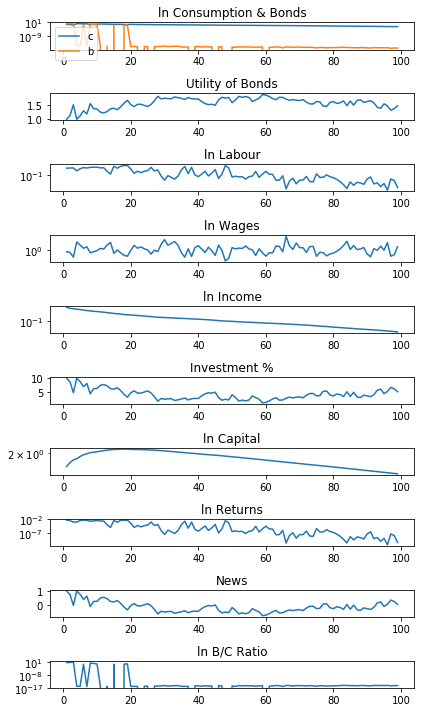

<Figure size 432x288 with 0 Axes>

In [128]:
% matplotlib inline
params = {'etaZ': 0.2, 'sigmaZ': 0.8, 'zbar': 1.0, 'sigmaN': 0.2, 
          'inflation': 0.01, 'interest': 0.01, 'depreciation': 0.01, 
          'g_min': 0.9, 'g_max': 1-1e-4, 'f_min': 1.0, 'f_max': 2, 
          'n_cons': 10, 'n_theta': 1, 'n_persistence': 0.9, 
          'gamma': 1.0, 'alpha': 0.33, 'rho': -3.23, 'shock': 1.0}

start = dict(z=1, c=1, n=1, b=1, w=1, k=1, q=0.1, 
             gt=0.8, ft=.5, income=100, news=1, xiz=0, xin=0)
start = np.array([v for _,v in start.items()])

T = 1e2
np.random.seed(40)
view = (1, int(T))


df = simulate(start, params, T)
df = df.iloc[view[0]:view[1],:]

graphs = {
        'ln Consumption & Bonds' : [df.loc[:,['c','b']], True],
        'Utility of Bonds' : [df.ft, False],
        'ln Labour' : [df.n, True],
        'ln Wages' : [df.w, True],
        'ln Income' : [df.income, True],
        'Investment %' : [df.inv, False],
        'ln Capital' : [df.k, True],
        'ln Returns' : [df.q, True],
        'News' : [df.news, False],
        'ln B/C Ratio' : [df.bc, True],
    }


axs = model.simulation_graph(graphs, size = (6, 10))
axs['ln Returns'].axhline(params['interest'], color='red', linewidth=0.5)
plt.savefig('/Users/fedemoro/Desktop/test.pdf',format = 'pdf')

In [127]:
param_bounds = {
    # Restrict noise params to be constant
    'etaZ': (0.2,0.2), 'sigmaZ': (0.8,0.8), 'sigmaN': (0.2,0.2), 
    # Realistic monthly values - 0% to 5%
    'inflation': (0.0,0.05), 'interest': (0.0,0.05), 'depreciation': (0.0,0.05),
    # Saving and bond parameters
    'g_min': (0.0,0.99), 'g_max': (0.0,0.99), 'f_min': (0.0,1e1), 'f_max': (1e1,1e3),
    # News parameters
    'n_cons': (0.1,10), 'n_theta': (0.1,10), 'n_persistence': (0.0,0.99),
    # Production & Household
    'zbar': (1.0,1.0), 'gamma': (1.0,10.0), 'alpha': (0.1,0.9), 'rho': (-1e4,-1e-1), 
    # No shocks for now
    'shock': (0.0,0.0)}

n = 5
param_steps = {'etaZ': 0, 'sigmaZ': 0, 'sigmaN': 0, 'inflation': 0, 'interest': 0, 'depreciation': 0,
    'g_min': n, 'g_max': n, 'f_min': n, 'f_max': n, 'n_cons': n, 'n_theta': n, 'n_persistence': n,
    'zbar': 0, 'gamma': 0, 'alpha': n, 'rho': n, 'shock': 0}

In [119]:
# Generate the whole set of parameters
params = {'etaZ': 0.2, 'sigmaZ': 0.8, 'zbar': 1.0, 'sigmaN': 0.2, 
          'inflation': 0.01, 'interest': 0.01, 'depreciation': 0.01, 
          'g_min': 0.8, 'g_max': 0.99, 'f_min': 1.0, 'f_max': 100, 
          'n_cons': 1, 'n_theta': 1, 'n_persistence': 0.8, 
          'gamma': 1.0, 'alpha': 0.5, 'rho': -1, 'shock': 0.0}

constants = [k for k,v in param_steps.items() if v==0]
ranges = {k:np.linspace(*v, param_steps[k]) for k,v in param_bounds.items()}
ranges = {k:v for k,v in ranges.items() if v.size!=0}

In [10]:
results = pd.DataFrame(columns = list(ranges.keys()))

In [11]:
from itertools import product

var = list(ranges.keys())

for tup in product(*list(ranges.values())):
    # Generate unique parameter set
    p = dict(params)
    for combo in zip(var, tup):
        p[combo[0]] = combo[1]
    #df = simulate(start)


In [12]:
def dead_economy(df, epsilon):
    return df.c.iloc[-1] < epsilon

In [23]:
# CES
def lhs_CES(cons: float, z: float, k:float, alpha: float, gamma: float, r: float, rho: float) -> float:
        pt1 = 2 * gamma * (1+r) / ((z ** 2) * (1 - alpha) ** (2 / rho))
        pt2 = cons ** 2
        pt3 = (1 - alpha*(z * k / cons) ** rho) ** ((2 - rho) / rho)
        print(pt1, pt2, pt3)
        return pt1 * pt2 * pt3

def rhs_CES(cons: float, gti: float, ft: float) -> float:
    return 1 - (ft * cons) / (gti - cons)
    

def bisection_CES(z:float, income:float, k:float, gt_:float, ft_:float, p:dict, err:float=1e-2)->float:
    assert gt_ * income > 0
    # Define the left and right hand sides of the equations
    diff = lambda c: rhs_CES(c, gt_ * income, ft_) - lhs_CES(c, z, k, p['alpha'], p['gamma'], p['interest'], p['rho'])
    
    # Initial guess at the next options for 
    a = k * z * (p['alpha'] ** (1 / p['rho'])) 
    if a > gt_ * income:
        print("Bad boundaries, setting c=g")
        return gt_ * income
    
    x = [a, 0.5 * (gt_*income + a), gt_*income]
    print(x)
    
    #guess = np.min([gt_*income, k * z * (p['alpha'] ** (1 / p['rho']))])
    #x = [0, guess / 2, guess]
    abs_lst = [abs(diff(i)) for i in x[:2]]
    
    # Apply bi-section method
    while min(abs_lst) >= err:
        test = np.sign([diff(i) for i in x])
        if test[0] == test[1]:
            x = [x[1], (x[1] + x[2]) / 2, x[2]]
        elif test[1] == test[2]:
            x = [x[0], (x[0] + x[1]) / 2, x[1]]

        abs_lst = [abs(diff(i)) for i in x[:2]]

    return x[np.argmin(abs_lst)]